This is a compilation of data by a company experiencing a high attrition rate of customers in its ISP segment that is  eroding its revenue base. 

A random sample of 9966 active customers as of March 2015 end was drawn from database. Their historical data of 3 months has been provided with the information such as Use Pattern, Payments, Default, Call Centre Information and etc. For the modeling phase, churns in next 2 months have been given with their churn date. For Validation , a random sample of 4986 active customers as of July 2015 end has been given with their historical 3 months information same as of modeling phase.

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Input given datasets

In [35]:
up=pd.read_excel('H:\data science\exl eq 2017\Stage 1.EXL_EQ2017_Telecom_Data Set_Final Ver6.0.xlsx',sheetname='Use Pattern',skiprows=5).drop('Unnamed: 0',1)

In [36]:
dc=pd.read_excel('H:\data science\exl eq 2017\Stage 1.EXL_EQ2017_Telecom_Data Set_Final Ver6.0.xlsx',sheetname='Call Centre Data',skiprows=5).drop('Unnamed: 0',1)

Following support has been taken from R-language for missing value imputations using knn-imputation technique
***
library(VIM)  
demographics=read.csv(file.choose(), header=T, na.strings=c("", "NA"))  
demographics2=kNN(demographics, k=4)  
demo=subset(demographics2, select=Account_Number:Churn_Date)  
write.table(demo, "H:/data science/exl eq 2017/demo", sep=",", row.names=F)  

In [37]:
dd = pd.read_excel('H:\data science\exl eq 2017\demo.xlsx')

In [38]:
len(dd)

14952

In [39]:
dd.Staus.value_counts()

1    14384
0      568
Name: Staus, dtype: int64

In [40]:
dd.dtypes

Account Number                            object
Commence Date                     datetime64[ns]
Address                                    int64
Scheme                                    object
Staus                                      int64
Gender                                     int64
Region                                    object
Sale of Equipment Status                  object
Age                                        int64
Equipment Warranty                        object
Salary Slab                                int64
Professional Info                         object
Age of Home                                int64
Equipment Warranty Expiry Date    datetime64[ns]
Churn Date                                object
Churn                                      int64
warranty_active                            int64
post_warranty_life                         int64
tenure                                     int64
eqipment_warranty_length                   int64
dtype: object

In [41]:
dd['Commence Date'] =  pd.to_datetime(dd['Commence Date'])
dd['Equipment Warranty Expiry Date'] =  pd.to_datetime(dd['Equipment Warranty Expiry Date'])
dd['Churn Date'] =  pd.to_datetime(dd['Churn Date'])

Taking base date as 31st May 2015 for modelling and 31st July 2015 for validation account numbers, creating new features :
****
post_warranty_life = number of days availing service after warranty expiration  
tenure = life of customer from commence date to base date/churn date  
equipment_warranty_length = life length of ISP instrument in warranty zone

In [42]:
import datetime
post_warranty_life = []

for i in range(len(dd)):
    if dd.Churn[i] == 0:
        if dd['Account Number'][i].startswith('M') == True:
            fif = datetime.datetime(2015, 5, 31) - dd['Equipment Warranty Expiry Date'][i]
            post_warranty_life.append(fif.days)
        if dd['Account Number'][i].startswith('V') == True:
            fif = datetime.datetime(2015, 7, 31) - dd['Equipment Warranty Expiry Date'][i]
            post_warranty_life.append(fif.days)
    elif dd.Churn[i] == 1:
        diff = dd['Churn Date'][i] - dd['Equipment Warranty Expiry Date'][i]
        post_warranty_life.append(diff.days)        
dd['post_warranty_life'] = post_warranty_life

import datetime
tenure = []
for i in range(len(dd)):
    if dd.Churn[i] == 0:
        if dd['Account Number'][i].startswith('M') == True:
            fif = datetime.datetime(2015, 5, 31) - dd['Commence Date'][i]
            tenure.append(fif.days)
        if dd['Account Number'][i].startswith('V') == True:
            fif = datetime.datetime(2015, 7, 31) - dd['Commence Date'][i]
            tenure.append(fif.days)
    elif dd.Churn[i] == 1:
        diff = dd['Churn Date'][i] - dd['Commence Date'][i]
        tenure.append(diff.days)
dd['tenure'] = tenure

import datetime
eqipment_warranty_length = []
for i in range(len(dd)):
    diff = dd['Equipment Warranty Expiry Date'][i] - dd['Commence Date'][i]
    eqipment_warranty_length.append(diff.days)
        
dd['eqipment_warranty_length'] = eqipment_warranty_length

Reducing the number of classes in **Salary Slab** and **Professional Info** as given in the dataset appendix

In [43]:
class_mapping = {1:1,
                 2:1,
                 3:1,
                4:2,
                5:2,
                6:2,
                7:3,
                8:3,
                9:3,
                10:4,
                11:4, 
                12:4,
                13:4
                }

dd['Salary Slab'] = dd['Salary Slab'].map(class_mapping)

In [44]:
class_mapping = {0:'Missing',
                 1:'Unknown',
                 2:'Accounting',
                 3:'Unknown',
                4:'Unknown',
                5:'Financial Sector',
                6:'Financial Sector',
                7:'General Labour',
                8:'Financial Sector',
                9:'Pharmacueticals',
                10:'Academics',
                11:'Automotive', 
                12:'Banking',
                13:'Banking',
                 15:'Financial Sector',
                 14:'Banking',
                 16:'Banking',
                 17:'Defence',
                 18:'Banking',
                 19:'Others',
                 15:'Financial Sector',
                 20:'Financial Sector'
                }

dd['Professional Info'] = dd['Professional Info'].map(class_mapping)

In [45]:
dd['Address'] = dd['Address'].map({'VALID':1,'INVALID':0})
dd['Staus'] = dd['Staus'].map({'Open':1,'Closed':0})
dd['Gender'] = dd['Gender'].map({'Male':1,'Female':0})

In [46]:
demo = dd.copy()

In [47]:
demo.head(5)

,Account Number,Commence Date,Address,Scheme,Staus,Gender,Region,Sale of Equipment Status,Age,Equipment Warranty,Salary Slab,Professional Info,Age of Home,Equipment Warranty Expiry Date,Churn Date,Churn,warranty_active,post_warranty_life,tenure,eqipment_warranty_length
0,M1,2011-11-04,NaN,KLA,NaN,NaN,Northern,RENTED,70,Three Full Years,1,NaN,17,2015-04-03,NaT,0,0,58,1304,1246
1,M2,2011-11-28,NaN,PPL,NaN,NaN,Western,RENTED,55,Three Full Years,1,NaN,22,2015-04-03,NaT,0,0,58,1280,1222
2,M3,2011-12-06,NaN,KLA,NaN,NaN,Eastern,RENTED,64,Three Full Years,1,NaN,17,2016-04-03,NaT,0,1,-308,1272,1580
3,M4,2011-10-28,NaN,MXX,NaN,NaN,Northern,RENTED,66,Three Full Years,1,NaN,22,2015-04-03,NaT,0,0,58,1311,1253
4,M5,2015-01-18,NaN,PRP,NaN,NaN,Western,RENTED,52,Full Year,1,NaN,12,2016-01-03,NaT,0,1,-217,133,350


In [16]:
demo.to_excel('H:/data science/exl eq 2017/demo.xlsx')

After preparing the dataset based on demographic information, we proced to study usage pattern characteristics in terms of usage per month, payments per month, deault amount per month and number of enquiries made.

**Usage Pattern**

In [48]:
up.columns

Index(['Account Number ', 'Used pattern in hours',
       'Usage Post Limit Utilization in hrs', 'data used Gb', 'YYYYMM',
       'usage_gbph', 'usage_post_limit', 'usage_hrs'],
      dtype='object')

In [49]:
up.head()

,Account Number,Used pattern in hours,Usage Post Limit Utilization in hrs,data used Gb,YYYYMM,usage_gbph,usage_post_limit,usage_hrs
0,M1,717.90,0,43.80,201501,0.061011,0,717.90
1,M1,662.42,0,110.35,201502,0.166586,0,662.42
2,M1,634.68,0,109.10,201503,0.171898,0,634.68
3,M2,696.12,5,98.40,201501,0.140347,1,701.12
4,M2,652.40,0,70.90,201502,0.108676,0,652.40


In [50]:
up = pd.get_dummies(up,columns=['YYYYMM'])

In [51]:
up.head()

,Account Number,Used pattern in hours,Usage Post Limit Utilization in hrs,data used Gb,usage_gbph,usage_post_limit,usage_hrs,YYYYMM_201501,YYYYMM_201502,YYYYMM_201503,YYYYMM_201505,YYYYMM_201506,YYYYMM_201507
0,M1,717.90,0,43.80,0.061011,0,717.90,1.0,0.0,0.0,0.0,0.0,0.0
1,M1,662.42,0,110.35,0.166586,0,662.42,0.0,1.0,0.0,0.0,0.0,0.0
2,M1,634.68,0,109.10,0.171898,0,634.68,0.0,0.0,1.0,0.0,0.0,0.0
3,M2,696.12,5,98.40,0.140347,1,701.12,1.0,0.0,0.0,0.0,0.0,0.0
4,M2,652.40,0,70.90,0.108676,0,652.40,0.0,1.0,0.0,0.0,0.0,0.0


In the below code, I'll drop three columns. However, their effect has been converted to *usage_gbph* which represents usage per month per hour 

In [52]:
up.drop(['Used pattern in hours', 'data used Gb'], axis=1, inplace=True)

In [53]:
up.head()

,Account Number,Usage Post Limit Utilization in hrs,usage_gbph,usage_post_limit,usage_hrs,YYYYMM_201501,YYYYMM_201502,YYYYMM_201503,YYYYMM_201505,YYYYMM_201506,YYYYMM_201507
0,M1,0,0.061011,0,717.90,1.0,0.0,0.0,0.0,0.0,0.0
1,M1,0,0.166586,0,662.42,0.0,1.0,0.0,0.0,0.0,0.0
2,M1,0,0.171898,0,634.68,0.0,0.0,1.0,0.0,0.0,0.0
3,M2,5,0.140347,1,701.12,1.0,0.0,0.0,0.0,0.0,0.0
4,M2,0,0.108676,0,652.40,0.0,1.0,0.0,0.0,0.0,0.0


modelling dataset has usage pattern information of Jan, Feb, March 2015 whereas validation dataset has usage paattern information of months April, May, June 2015. Combining corresponding months in the following code to because intersection among these corresponding months usage is zero.

In [54]:
r,c = up.shape
for i in range(0,r):
    if(up.iloc[i,5]==1 or up.iloc[i,8]==1): 
        up.iloc[i,5] = 1
    elif(up.iloc[i,6]==1 or up.iloc[i,9]==1):
        up.iloc[i,6] = 1
    elif(up.iloc[i,7]==1 or up.iloc[i,10]==1):
        up.iloc[i,7] = 1

In [55]:
up.drop(['YYYYMM_201505','YYYYMM_201506','YYYYMM_201507'], axis=1,inplace=True)

In [56]:
up.head()

,Account Number,Usage Post Limit Utilization in hrs,usage_gbph,usage_post_limit,usage_hrs,YYYYMM_201501,YYYYMM_201502,YYYYMM_201503
0,M1,0,0.061011,0,717.90,1.0,0.0,0.0
1,M1,0,0.166586,0,662.42,0.0,1.0,0.0
2,M1,0,0.171898,0,634.68,0.0,0.0,1.0
3,M2,5,0.140347,1,701.12,1.0,0.0,0.0
4,M2,0,0.108676,0,652.40,0.0,1.0,0.0


In [57]:
for i in range(len(up)):
    for j in range(5,8):
        up.iloc[i,j] = up.iloc[i,j]*up.iloc[i,2]

In [58]:
up.drop(['usage_gbph','usage_hrs'], axis=1,inplace=True)

In [59]:
up.head()

,Account Number,Usage Post Limit Utilization in hrs,usage_post_limit,YYYYMM_201501,YYYYMM_201502,YYYYMM_201503
0,M1,0,0,0.061011,0.000000,0.000000
1,M1,0,0,0.000000,0.166586,0.000000
2,M1,0,0,0.000000,0.000000,0.171898
3,M2,5,1,0.140347,0.000000,0.000000
4,M2,0,0,0.000000,0.108676,0.000000


In [60]:
up1 = up.copy()

In [61]:
len(up1)

41730

Merging rows having same account number by addition :

In [62]:
unq, unq_inv = np.unique(up1.iloc[:, 0], return_inverse=True)
out = np.zeros((len(unq), up1.shape[1]), dtype=up1.dtypes)
out[:, 0] = unq
np.add.at(out[:, 1:], unq_inv, up1.iloc[:, 1:])

In [63]:
out = pd.DataFrame(out)

In [64]:
out.head(5)

,0,1,2,3,4,5
0,M1,0,0,0.0610113,0.166586,0.171898
1,M10,0,0,0.0651076,0.0526005,0.0505258
2,M100,0,0,0.244951,0.245436,0.264728
3,M1000,0,0,0.0032228,0,0
4,M10000,597,2,0.105581,0.128843,0.141158


In [65]:
out.columns = [['Account Number','Usage Post Limit Utilization in hrs', 'usage_post_limit', 'usage_month1','usage_month2','usage_month3']]

In [66]:
len(out['Account Number'].unique())

14539

In [67]:
out.head()

,Account Number,Usage Post Limit Utilization in hrs,usage_post_limit,usage_month1,usage_month2,usage_month3
0,M1,0,0,0.0610113,0.166586,0.171898
1,M10,0,0,0.0651076,0.0526005,0.0505258
2,M100,0,0,0.244951,0.245436,0.264728
3,M1000,0,0,0.0032228,0,0
4,M10000,597,2,0.105581,0.128843,0.141158


In [68]:
comu = demo.copy

In [69]:
comu = demo.merge(out, on ='Account Number', how='outer') 

Now we have successfully appended usage characteristics to our original dataframe

In [70]:
comu.head()

,Account Number,Commence Date,Address,Scheme,Staus,Gender,Region,Sale of Equipment Status,Age,Equipment Warranty,Salary Slab,Professional Info,Age of Home,Equipment Warranty Expiry Date,Churn Date,Churn,warranty_active,post_warranty_life,tenure,eqipment_warranty_length,Usage Post Limit Utilization in hrs,usage_post_limit,usage_month1,usage_month2,usage_month3
0,M1,2011-11-04,NaN,KLA,NaN,NaN,Northern,RENTED,70.0,Three Full Years,1.0,NaN,17.0,2015-04-03,NaT,0.0,0.0,58.0,1304.0,1246.0,0,0,0.0610113,0.166586,0.171898
1,M2,2011-11-28,NaN,PPL,NaN,NaN,Western,RENTED,55.0,Three Full Years,1.0,NaN,22.0,2015-04-03,NaT,0.0,0.0,58.0,1280.0,1222.0,5,1,0.140347,0.108676,0.208766
2,M3,2011-12-06,NaN,KLA,NaN,NaN,Eastern,RENTED,64.0,Three Full Years,1.0,NaN,17.0,2016-04-03,NaT,0.0,1.0,-308.0,1272.0,1580.0,0,0,0.0946965,0.0938905,0.100978
3,M4,2011-10-28,NaN,MXX,NaN,NaN,Northern,RENTED,66.0,Three Full Years,1.0,NaN,22.0,2015-04-03,NaT,0.0,0.0,58.0,1311.0,1253.0,0,0,0.0789796,0.0847407,0.0946172
4,M5,2015-01-18,NaN,PRP,NaN,NaN,Western,RENTED,52.0,Full Year,1.0,NaN,12.0,2016-01-03,NaT,0.0,1.0,-217.0,133.0,350.0,0,0,0.0437798,0.00903695,0.00234024


In [71]:
comu1 = comu.copy()

Loading the defaults data as dataframe to add its value to our dataset before modelling  
**Defaults Data**

In [72]:
df2=pd.read_excel('H:\data science\exl eq 2017\Stage 1.EXL_EQ2017_Telecom_Data Set_Final Ver6.0.xlsx',sheetname='Defaults data',skiprows=5).drop('Unnamed: 0',1)

In [73]:
df2.head()

,Account Number,date of default,Default sum
0,M100,2015-02-25,1037.2
1,M104,2015-03-13,611.8
2,M114,2015-03-07,2193.5
3,M125,2015-03-02,507.8
4,M132,2015-02-27,1405.5


In [74]:
len(df2)

2471

In [75]:
df2['month'] = df2['date of default'].dt.month

In [76]:
df2 = pd.get_dummies(df2, columns=['month'])

In [77]:
df2.dtypes

Account Number             object
date of default    datetime64[ns]
Default sum               float64
month_1                   float64
month_2                   float64
month_3                   float64
month_5                   float64
month_6                   float64
month_7                   float64
dtype: object

In [78]:
df2.head()

,Account Number,date of default,Default sum,month_1,month_2,month_3,month_5,month_6,month_7
0,M100,2015-02-25,1037.2,0.0,1.0,0.0,0.0,0.0,0.0
1,M104,2015-03-13,611.8,0.0,0.0,1.0,0.0,0.0,0.0
2,M114,2015-03-07,2193.5,0.0,0.0,1.0,0.0,0.0,0.0
3,M125,2015-03-02,507.8,0.0,0.0,1.0,0.0,0.0,0.0
4,M132,2015-02-27,1405.5,0.0,1.0,0.0,0.0,0.0,0.0


modelling dataset has usage pattern information of Jan, Feb, March 2015 whereas validation dataset has usage paattern information of months May, June, July 2015. Combining corresponding months in the following code to because intersection among these corresponding months usage is zero.

In [79]:
r,c = df2.shape
for i in range(0,r):
    if(df2.iloc[i,3]==1 or df2.iloc[i,6]==1): 
        df2.iloc[i,3] = 1
    elif(df2.iloc[i,4]==1 or df2.iloc[i,7]==1):
        df2.iloc[i,4] = 1
    elif(df2.iloc[i,5]==1 or df2.iloc[i,8]==1):
        df2.iloc[i,5] = 1

In [80]:
df2.drop(['month_5','month_6','month_7'], axis=1, inplace=True)

In [81]:
df2.head()

,Account Number,date of default,Default sum,month_1,month_2,month_3
0,M100,2015-02-25,1037.2,0.0,1.0,0.0
1,M104,2015-03-13,611.8,0.0,0.0,1.0
2,M114,2015-03-07,2193.5,0.0,0.0,1.0
3,M125,2015-03-02,507.8,0.0,0.0,1.0
4,M132,2015-02-27,1405.5,0.0,1.0,0.0


In [82]:
for i in range(len(df2)):
    for j in range(3,6):
        df2.iloc[i,j] = df2.iloc[i,j]*df2.iloc[i,2]

In [83]:
df2.drop(['date of default', 'Default sum'], axis=1, inplace=True)

In [84]:
df2.head()

,Account Number,month_1,month_2,month_3
0,M100,0.0,1037.2,0.0
1,M104,0.0,0.0,611.8
2,M114,0.0,0.0,2193.5
3,M125,0.0,0.0,507.8
4,M132,0.0,1405.5,0.0


Merging rows having same account number by addition :

In [85]:
unq, unq_inv = np.unique(df2.iloc[:, 0], return_inverse=True)
default_out = np.zeros((len(unq), df2.shape[1]), dtype=df2.dtypes)
default_out[:, 0] = unq
np.add.at(default_out[:, 1:], unq_inv, df2.iloc[:, 1:])

In [86]:
default_out = pd.DataFrame(default_out)

In [87]:
default_out.columns = [['Account Number', 'default_month1', 'default_month2', 'default_month3']]

In [88]:
default_out.head()

,Account Number,default_month1,default_month2,default_month3
0,M100,0,1037.2,0
1,M1002,938.4,938.4,938.4
2,M1039,0,1066.8,735.8
3,M104,0,0,611.8
4,M1045,0,0,649.8


In [89]:
comu1.head(1)

,Account Number,Commence Date,Address,Scheme,Staus,Gender,Region,Sale of Equipment Status,Age,Equipment Warranty,Salary Slab,Professional Info,Age of Home,Equipment Warranty Expiry Date,Churn Date,Churn,warranty_active,post_warranty_life,tenure,eqipment_warranty_length,Usage Post Limit Utilization in hrs,usage_post_limit,usage_month1,usage_month2,usage_month3
0,M1,2011-11-04,NaN,KLA,NaN,NaN,Northern,RENTED,70.0,Three Full Years,1.0,NaN,17.0,2015-04-03,NaT,0.0,0.0,58.0,1304.0,1246.0,0,0,0.0610113,0.166586,0.171898


In [90]:
comu1 = comu1.merge(default_out, on ='Account Number', how='outer') 

In [91]:
comu1.shape

(14998, 28)

Loading the payments data as dataframe to add its value to our dataset before modelling  
**Payments Data**

In [92]:
pay=pd.read_excel('H:\data science\exl eq 2017\Stage 1.EXL_EQ2017_Telecom_Data Set_Final Ver6.0.xlsx',sheetname='Payments Data',skiprows=5).drop('Unnamed: 0',1)

In [93]:
pay.head()

,Account Number,Realization Date,Sum,Mode
0,M1,2015-03-01,1209.810,Card II TYPE
1,M1,2015-02-01,1209.810,Card II TYPE
2,M1,2015-01-01,1209.810,Card II TYPE
3,M2,2015-03-01,751.695,Card II TYPE
4,M2,2015-02-01,751.695,Card II TYPE


In [94]:
pay.columns

Index(['Account Number', 'Realization Date', 'Sum', 'Mode '], dtype='object')

Month is an important feature for pattern identification, hence, breaking it down into individual months

In [95]:
pay['month'] = pay['Realization Date'].dt.month

In [96]:
pay = pd.get_dummies(pay, columns=['Mode ', 'month'])

In [97]:
pay.head(1)

,Account Number,Realization Date,Sum,Mode _ Card I TYPE,Mode _ Card II TYPE,Mode _Other,Mode _Paper based/Post,month_1,month_2,month_3,month_5,month_6,month_7
0,M1,2015-03-01,1209.81,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


modelling dataset has usage pattern information of Jan, Feb, March 2015 whereas validation dataset has usage paattern information of months May, June, July 2015. Combining corresponding months in the following code to because intersection among these corresponding months usage is zero.

In [98]:
r,c = pay.shape
for i in range(0,r):
    if(pay.iloc[i,7]==1 or pay.iloc[i,10]==1): 
        pay.iloc[i,7] = 1
    elif(pay.iloc[i,8]==1 or pay.iloc[i,11]==1):
        pay.iloc[i,8] = 1
    elif(pay.iloc[i,9]==1 or pay.iloc[i,12]==1):
        pay.iloc[i,9] = 1

In [99]:
pay.drop(['month_5','month_6','month_7'], axis=1, inplace=True)

In [100]:
pay.head()

,Account Number,Realization Date,Sum,Mode _ Card I TYPE,Mode _ Card II TYPE,Mode _Other,Mode _Paper based/Post,month_1,month_2,month_3
0,M1,2015-03-01,1209.810,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,M1,2015-02-01,1209.810,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,M1,2015-01-01,1209.810,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,M2,2015-03-01,751.695,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,M2,2015-02-01,751.695,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [101]:
for i in range(len(pay)):
    for j in range(7,10):
        pay.iloc[i,j] = pay.iloc[i,j]*pay.iloc[i,2]

In [102]:
pay.rename(columns={'month_1': 'payments_month1', 'month_2': 'payments_month2', 'month_3': 'payments_month3'}, inplace=True)

In [103]:
pay.head()

,Account Number,Realization Date,Sum,Mode _ Card I TYPE,Mode _ Card II TYPE,Mode _Other,Mode _Paper based/Post,payments_month1,payments_month2,payments_month3
0,M1,2015-03-01,1209.810,0.0,1.0,0.0,0.0,0.00,0.000,1209.810
1,M1,2015-02-01,1209.810,0.0,1.0,0.0,0.0,0.00,1209.810,0.000
2,M1,2015-01-01,1209.810,0.0,1.0,0.0,0.0,1209.81,0.000,0.000
3,M2,2015-03-01,751.695,0.0,1.0,0.0,0.0,0.00,0.000,751.695
4,M2,2015-02-01,751.695,0.0,1.0,0.0,0.0,0.00,751.695,0.000


In [104]:
pay1 = pay.copy()

In [105]:
pay1.drop('Realization Date', axis=1, inplace=True)

In [106]:
pay1.head(1)

,Account Number,Sum,Mode _ Card I TYPE,Mode _ Card II TYPE,Mode _Other,Mode _Paper based/Post,payments_month1,payments_month2,payments_month3
0,M1,1209.81,0.0,1.0,0.0,0.0,0.0,0.0,1209.81


Merging rows having same account number by addition :

In [107]:
unq, unq_inv = np.unique(pay1.iloc[:, 0], return_inverse=True)
pay_out = np.zeros((len(unq), pay1.shape[1]), dtype=pay1.dtypes)
pay_out[:, 0] = unq
np.add.at(pay_out[:, 1:], unq_inv, pay1.iloc[:, 1:])

In [108]:
pay_out = pd.DataFrame(pay_out)

In [109]:
pay_out.head()

,0,1,2,3,4,5,6,7,8
0,M1,3629.43,0,3,0,0,1209.81,1209.81,1209.81
1,M10,3515.09,0,3,0,0,1171.7,1171.7,1171.7
2,M1000,2604.42,0,3,0,0,868.14,868.14,868.14
3,M10000,2923.73,0,3,0,0,904.575,1009.58,1009.58
4,M1001,2896.11,0,3,0,0,965.37,965.37,965.37


In [110]:
pay_out.columns = [['Account Number','Sum','Mode _ Card I TYPE','Mode _ Card II TYPE','Mode _Other','Mode _Paper based/Post','payments_month1','payments_month2','payments_month3']]

In [111]:
comu3 = comu1.copy()

In [112]:
comu3 = comu3.merge(pay_out, on ='Account Number', how='outer') 

In [113]:
comu3.head()

,Account Number,Commence Date,Address,Scheme,Staus,Gender,Region,Sale of Equipment Status,Age,Equipment Warranty,Salary Slab,Professional Info,Age of Home,Equipment Warranty Expiry Date,Churn Date,Churn,warranty_active,post_warranty_life,tenure,eqipment_warranty_length,Usage Post Limit Utilization in hrs,usage_post_limit,usage_month1,usage_month2,usage_month3,default_month1,default_month2,default_month3,Sum,Mode _ Card I TYPE,Mode _ Card II TYPE,Mode _Other,Mode _Paper based/Post,payments_month1,payments_month2,payments_month3
0,M1,2011-11-04,NaN,KLA,NaN,NaN,Northern,RENTED,70.0,Three Full Years,1.0,NaN,17.0,2015-04-03,NaT,0.0,0.0,58.0,1304.0,1246.0,0,0,0.0610113,0.166586,0.171898,NaN,NaN,NaN,3629.43,0,3,0,0,1209.81,1209.81,1209.81
1,M2,2011-11-28,NaN,PPL,NaN,NaN,Western,RENTED,55.0,Three Full Years,1.0,NaN,22.0,2015-04-03,NaT,0.0,0.0,58.0,1280.0,1222.0,5,1,0.140347,0.108676,0.208766,NaN,NaN,NaN,2255.09,0,3,0,0,751.695,751.695,751.695
2,M3,2011-12-06,NaN,KLA,NaN,NaN,Eastern,RENTED,64.0,Three Full Years,1.0,NaN,17.0,2016-04-03,NaT,0.0,1.0,-308.0,1272.0,1580.0,0,0,0.0946965,0.0938905,0.100978,NaN,NaN,NaN,3193.15,0,3,0,0,1064.38,1064.38,1064.38
3,M4,2011-10-28,NaN,MXX,NaN,NaN,Northern,RENTED,66.0,Three Full Years,1.0,NaN,22.0,2015-04-03,NaT,0.0,0.0,58.0,1311.0,1253.0,0,0,0.0789796,0.0847407,0.0946172,NaN,NaN,NaN,4126.5,0,3,0,0,963.375,1674.75,1488.38
4,M5,2015-01-18,NaN,PRP,NaN,NaN,Western,RENTED,52.0,Full Year,1.0,NaN,12.0,2016-01-03,NaT,0.0,1.0,-217.0,133.0,350.0,0,0,0.0437798,0.00903695,0.00234024,NaN,NaN,NaN,2616.18,0,3,0,0,839.895,919.59,856.695


In [114]:
len(comu3)

14998

In [115]:
comu3.usage_post_limit = comu3.usage_post_limit.map({0:0,1:1,2:1,3:1})

In [116]:
len(comu3)

14998

In [117]:
comu3.head()

,Account Number,Commence Date,Address,Scheme,Staus,Gender,Region,Sale of Equipment Status,Age,Equipment Warranty,Salary Slab,Professional Info,Age of Home,Equipment Warranty Expiry Date,Churn Date,Churn,warranty_active,post_warranty_life,tenure,eqipment_warranty_length,Usage Post Limit Utilization in hrs,usage_post_limit,usage_month1,usage_month2,usage_month3,default_month1,default_month2,default_month3,Sum,Mode _ Card I TYPE,Mode _ Card II TYPE,Mode _Other,Mode _Paper based/Post,payments_month1,payments_month2,payments_month3
0,M1,2011-11-04,NaN,KLA,NaN,NaN,Northern,RENTED,70.0,Three Full Years,1.0,NaN,17.0,2015-04-03,NaT,0.0,0.0,58.0,1304.0,1246.0,0,0.0,0.0610113,0.166586,0.171898,NaN,NaN,NaN,3629.43,0,3,0,0,1209.81,1209.81,1209.81
1,M2,2011-11-28,NaN,PPL,NaN,NaN,Western,RENTED,55.0,Three Full Years,1.0,NaN,22.0,2015-04-03,NaT,0.0,0.0,58.0,1280.0,1222.0,5,1.0,0.140347,0.108676,0.208766,NaN,NaN,NaN,2255.09,0,3,0,0,751.695,751.695,751.695
2,M3,2011-12-06,NaN,KLA,NaN,NaN,Eastern,RENTED,64.0,Three Full Years,1.0,NaN,17.0,2016-04-03,NaT,0.0,1.0,-308.0,1272.0,1580.0,0,0.0,0.0946965,0.0938905,0.100978,NaN,NaN,NaN,3193.15,0,3,0,0,1064.38,1064.38,1064.38
3,M4,2011-10-28,NaN,MXX,NaN,NaN,Northern,RENTED,66.0,Three Full Years,1.0,NaN,22.0,2015-04-03,NaT,0.0,0.0,58.0,1311.0,1253.0,0,0.0,0.0789796,0.0847407,0.0946172,NaN,NaN,NaN,4126.5,0,3,0,0,963.375,1674.75,1488.38
4,M5,2015-01-18,NaN,PRP,NaN,NaN,Western,RENTED,52.0,Full Year,1.0,NaN,12.0,2016-01-03,NaT,0.0,1.0,-217.0,133.0,350.0,0,0.0,0.0437798,0.00903695,0.00234024,NaN,NaN,NaN,2616.18,0,3,0,0,839.895,919.59,856.695


At last, we add information from the call centre data to our dataframe. We shall add number of enquiries made by each customer corresponding to account numbers

In [118]:
dc=pd.read_excel('H:\data science\exl eq 2017\Stage 1.EXL_EQ2017_Telecom_Data Set_Final Ver6.0.xlsx',sheetname='Call Centre Data',skiprows=5).drop('Unnamed: 0',1)

In [119]:
dcm = dc.groupby('Account Number', sort=False)['no.of enquires'].sum()

In [120]:
dcm = pd.DataFrame(dcm)
dcm = dcm.reset_index()

In [121]:
dcm.head()

,Account Number,no.of enquires
0,M2,6
1,M5,1
2,M13,4
3,M15,3
4,M17,4


In [122]:
len(dcm)

5463

In [123]:
comu3 = comu3.merge(dcm, on ='Account Number', how='outer') 

In [124]:
comu3.head()

,Account Number,Commence Date,Address,Scheme,Staus,Gender,Region,Sale of Equipment Status,Age,Equipment Warranty,Salary Slab,Professional Info,Age of Home,Equipment Warranty Expiry Date,Churn Date,Churn,warranty_active,post_warranty_life,tenure,eqipment_warranty_length,Usage Post Limit Utilization in hrs,usage_post_limit,usage_month1,usage_month2,usage_month3,default_month1,default_month2,default_month3,Sum,Mode _ Card I TYPE,Mode _ Card II TYPE,Mode _Other,Mode _Paper based/Post,payments_month1,payments_month2,payments_month3,no.of enquires
0,M1,2011-11-04,NaN,KLA,NaN,NaN,Northern,RENTED,70.0,Three Full Years,1.0,NaN,17.0,2015-04-03,NaT,0.0,0.0,58.0,1304.0,1246.0,0,0.0,0.0610113,0.166586,0.171898,NaN,NaN,NaN,3629.43,0,3,0,0,1209.81,1209.81,1209.81,NaN
1,M2,2011-11-28,NaN,PPL,NaN,NaN,Western,RENTED,55.0,Three Full Years,1.0,NaN,22.0,2015-04-03,NaT,0.0,0.0,58.0,1280.0,1222.0,5,1.0,0.140347,0.108676,0.208766,NaN,NaN,NaN,2255.09,0,3,0,0,751.695,751.695,751.695,6.0
2,M3,2011-12-06,NaN,KLA,NaN,NaN,Eastern,RENTED,64.0,Three Full Years,1.0,NaN,17.0,2016-04-03,NaT,0.0,1.0,-308.0,1272.0,1580.0,0,0.0,0.0946965,0.0938905,0.100978,NaN,NaN,NaN,3193.15,0,3,0,0,1064.38,1064.38,1064.38,NaN
3,M4,2011-10-28,NaN,MXX,NaN,NaN,Northern,RENTED,66.0,Three Full Years,1.0,NaN,22.0,2015-04-03,NaT,0.0,0.0,58.0,1311.0,1253.0,0,0.0,0.0789796,0.0847407,0.0946172,NaN,NaN,NaN,4126.5,0,3,0,0,963.375,1674.75,1488.38,NaN
4,M5,2015-01-18,NaN,PRP,NaN,NaN,Western,RENTED,52.0,Full Year,1.0,NaN,12.0,2016-01-03,NaT,0.0,1.0,-217.0,133.0,350.0,0,0.0,0.0437798,0.00903695,0.00234024,NaN,NaN,NaN,2616.18,0,3,0,0,839.895,919.59,856.695,1.0


In [125]:
comu3.shape

(14998, 37)

We have fairly modified our dataset and made it ready for statistical testing and hypothesis formulation.

In [127]:
comu3.to_excel('H:\data science\exl eq 2017\comu3_upluih.xlsx',index=False)
comu3 = pd.read_excel('H:\data science\exl eq 2017\comu3_upluih.xlsx')

Exporting and importing datasets might change the dtype of dates columns to objects. Regaining them back using following code:

In [60]:
comu3['Commence Date'] =  pd.to_datetime(comu3['Commence Date'])
comu3['Equipment Warranty Expiry Date'] =  pd.to_datetime(comu3['Equipment Warranty Expiry Date'])
comu3['Churn Date'] =  pd.to_datetime(comu3['Churn Date'])

In [61]:
comu3 = comu3.dropna(subset = ['Age'])

Our dataset *comu3* consists of both modelling and validation datapoints, in the following code, we split our original dataset into 'm' and 'v' dataframes. *m* is for modelling and *v* is that dataframe on whom predictions are to be made.

In [62]:
m_comu3 = comu3[comu3['Account Number'].str.startswith('M')]
v_comu3 = comu3[comu3['Account Number'].str.startswith('V')]

In [63]:
len(m_comu3)

9966

Once a customer's equipment warranty is expired, his expectancy of using the ISP instrument is drastically reduced. This can be seen in the following plot:

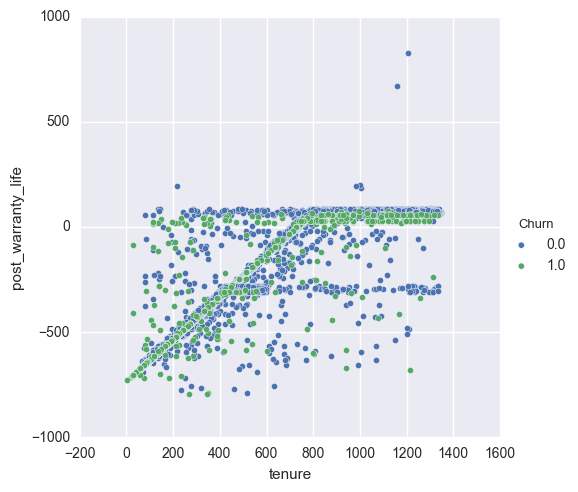

In [64]:
sns.pairplot(data=m_comu3,hue='Churn', x_vars='tenure', y_vars='post_warranty_life',size=5)
plt.savefig('tenure_postwarrantylife_mcomu3')

Customers with very low salary bracket churns the most. The churn rate decreases as the salary slab bracket profile increases(very low to high profile), opposite to the mean tenure which increases with the ascending salary bracket.		
				


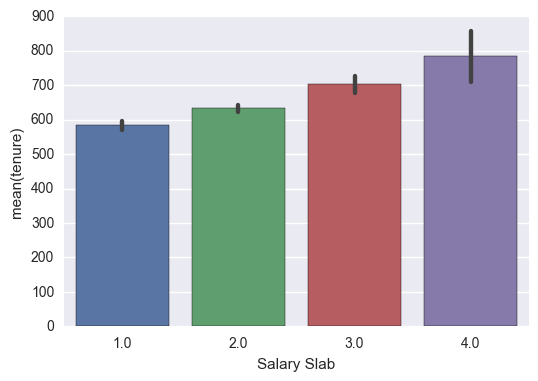

In [65]:
sns.barplot(x="Salary Slab", y="tenure", data=m_comu3)
plt.savefig('salayssalab_vs_tenure.jpg')

Customers in the profession of defence are most likely to churn while the customers in the profession of pharmaceuticals are least likely to churn.				
				


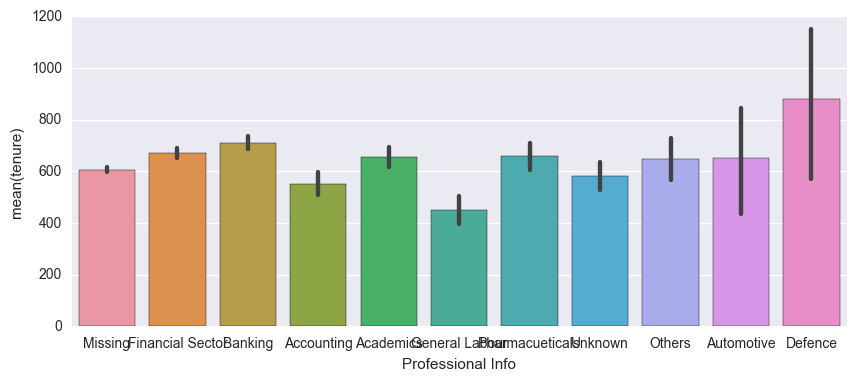

In [66]:
plt.figure(figsize=(10,4))
sns.barplot(x="Professional Info", y="tenure", data=m_comu3)
plt.savefig('profinfo_vs_tenure.jpg')

Customers with age of home above 14 are less likely to churn as compared to the customers with age of home less than 14.				
				


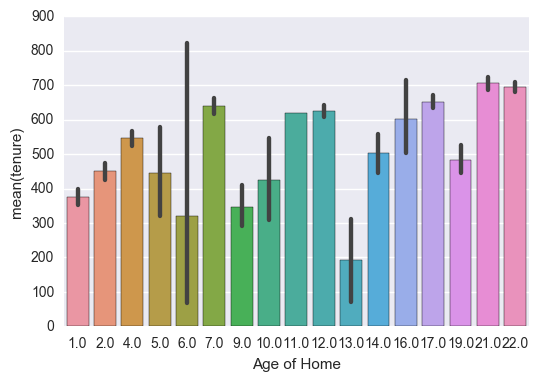

In [67]:
sns.barplot(x="Age of Home", y="tenure", data=m_comu3)
plt.savefig('ageofhome_vs_tenure.jpg')

Most people have opted for schemes PPL and PWR, followed by PRM, KLA and CNN. Scheme PPL has the highest churning customers, while no customer of PMM, however less churns.

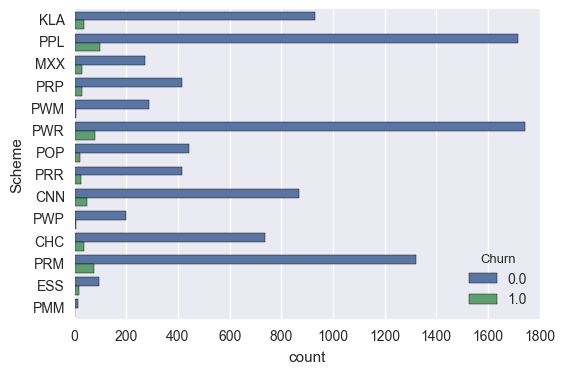

In [68]:
sns.countplot(y="Scheme", data=m_comu3, hue = 'Churn')
plt.savefig('scheme_vs_count.jpg')

Customers from western region are least likely to churn as compared to eastern , southern and northern regions. Eastern , southern and northern regions churn at similar rates.

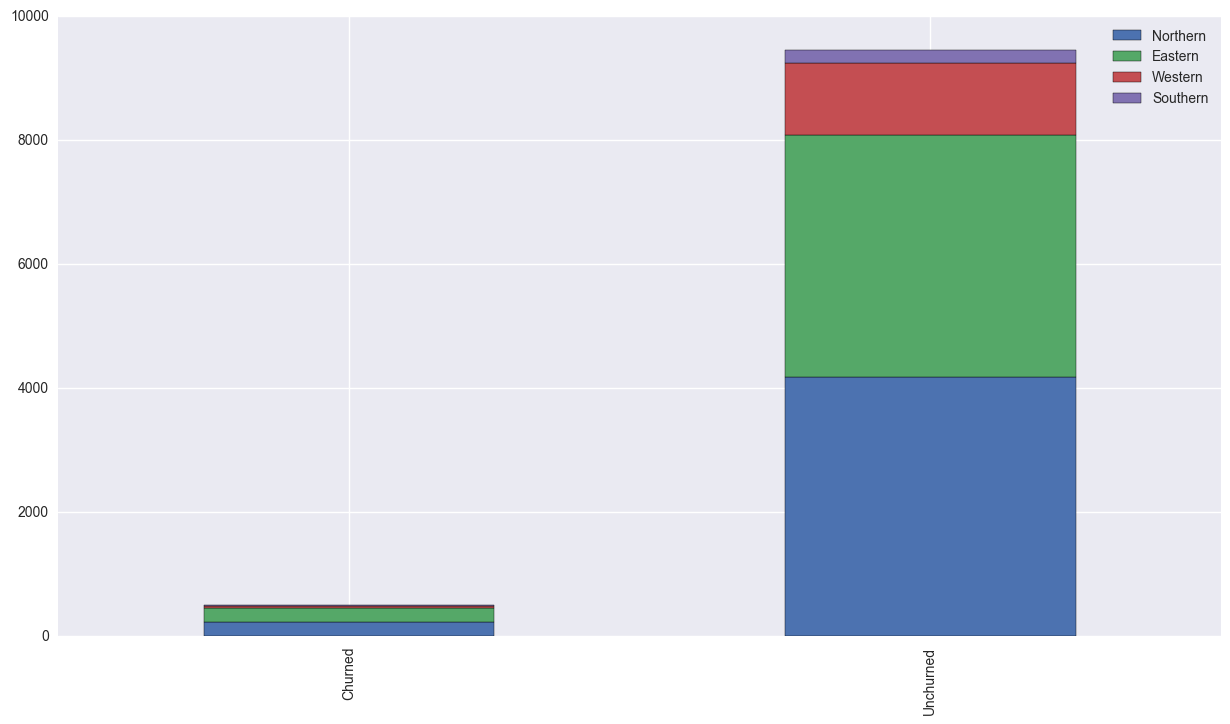

In [69]:
c_reg = m_comu3[m_comu3['Churn']==1]['Region'].value_counts()
uc_reg = m_comu3[m_comu3['Churn']==0]['Region'].value_counts()
m_comu3s = pd.DataFrame([c_reg,uc_reg])
m_comu3s.index = ['Churned','Unchurned']
m_comu3s.plot(kind='bar',stacked=True, figsize=(15,8))
plt.savefig('region.jpg')

Customers with closed status are more likely to churn than the open status customers.(Customer percent of closed status churn rate > customer percent of open status churn rate)

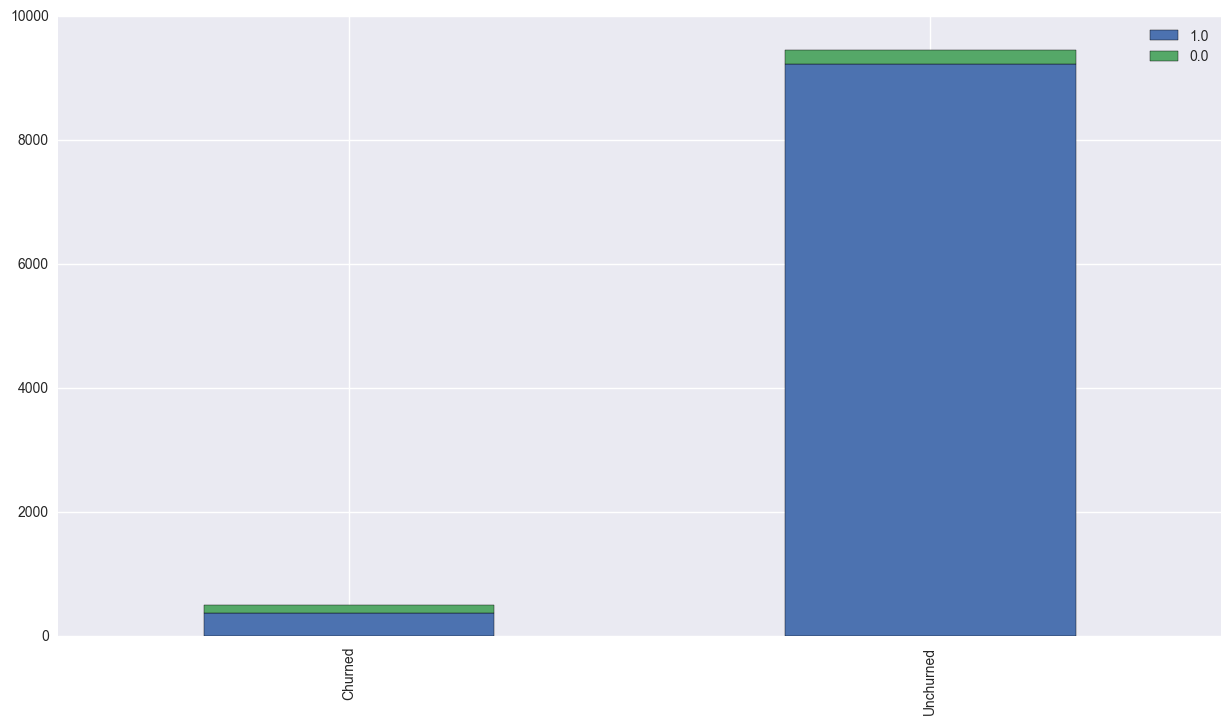

In [70]:
c_sch = m_comu3[m_comu3['Churn']==1]['Staus'].value_counts()
uc_sch = m_comu3[m_comu3['Churn']==0]['Staus'].value_counts()
m_comu3s = pd.DataFrame([c_sch,uc_sch])
m_comu3s.index = ['Churned','Unchurned']
m_comu3s.plot(kind='bar',stacked=True, figsize=(15,8))
plt.savefig('staus.jpg')

Customers with age above 50 are less likely to churn as compared to the customers of age less than 50.

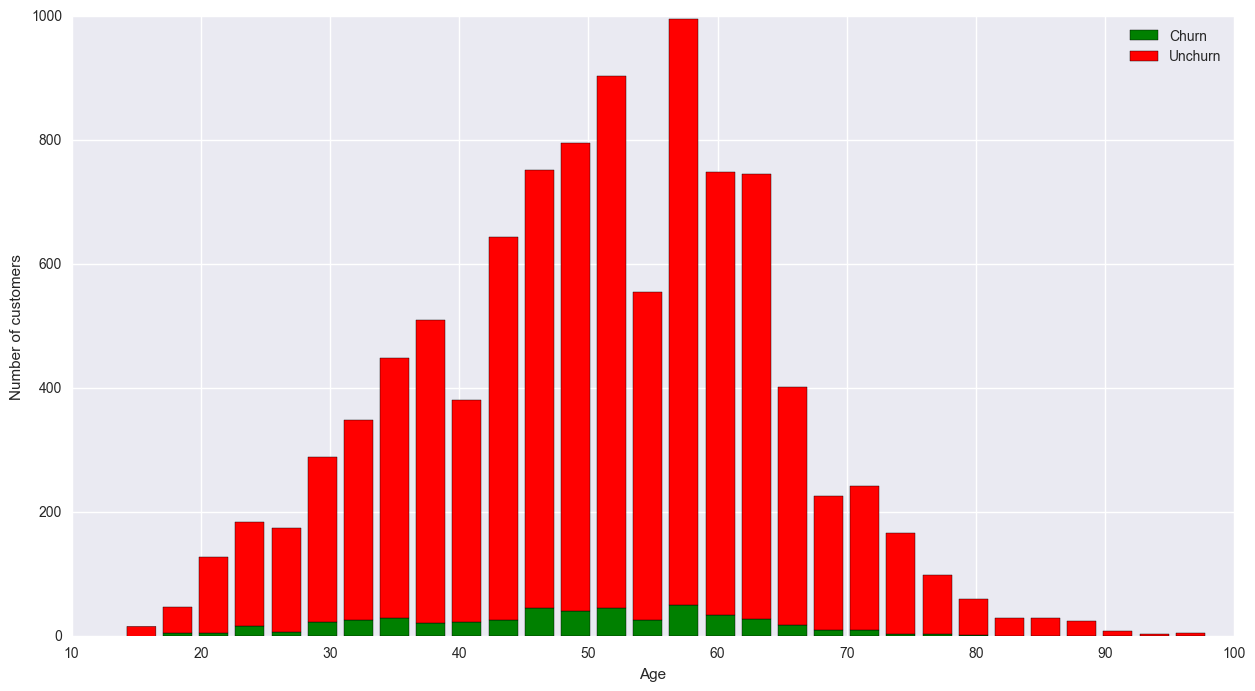

In [71]:
figure = plt.figure(figsize=(15,8))
plt.hist([m_comu3[m_comu3['Churn']==1]['Age'],m_comu3[m_comu3['Churn']==0]['Age']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Churn','Unchurn'])
plt.xlabel('Age')
plt.ylabel('Number of customers')
plt.legend()
plt.savefig('age_vs_churn.jpg')

There is no address effect regarding those who churn or unchurn (customer percent of invalid address who churn = customer percent of valid address who churn).

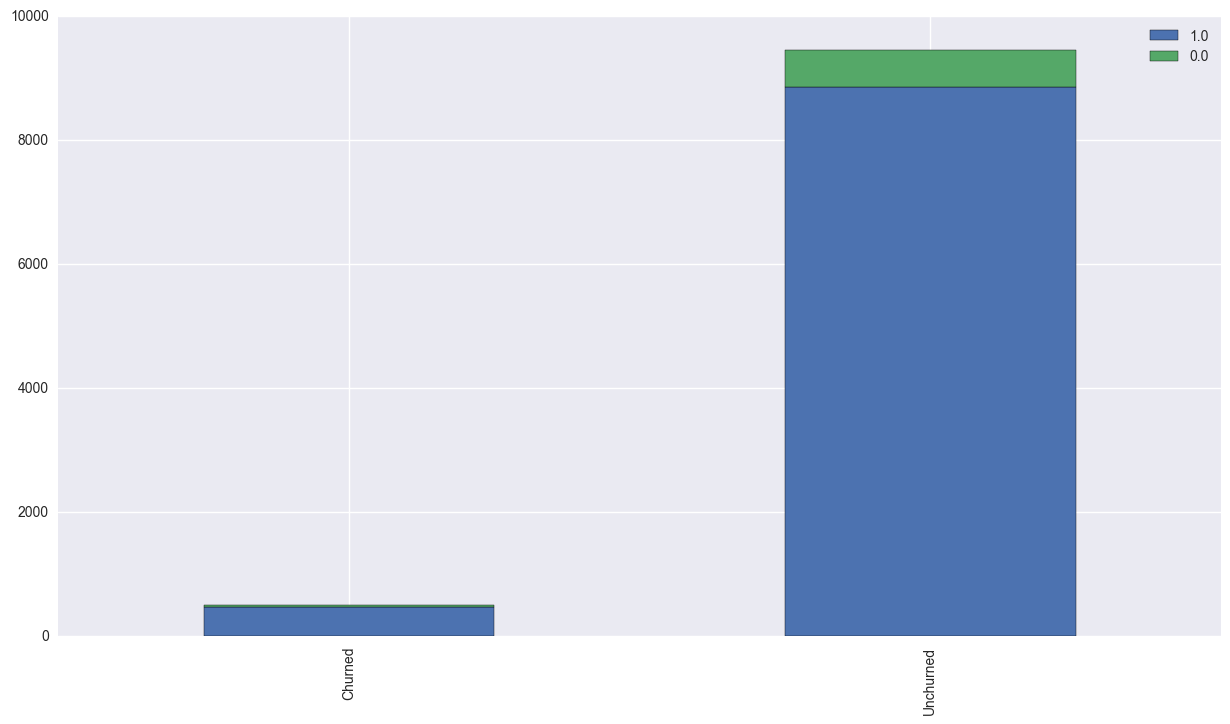

In [72]:
c_reg = m_comu3[m_comu3['Churn']==1]['Address'].value_counts()
uc_reg = m_comu3[m_comu3['Churn']==0]['Address'].value_counts()
m_comu3s = pd.DataFrame([c_reg,uc_reg])
m_comu3s.index = ['Churned','Unchurned']
m_comu3s.plot(kind='bar',stacked=True, figsize=(15,8))
plt.savefig('address.jpg')

Customers in the profession of defence are most likely to churn while the customers in the profession of pharmaceuticals are least likely to churn.

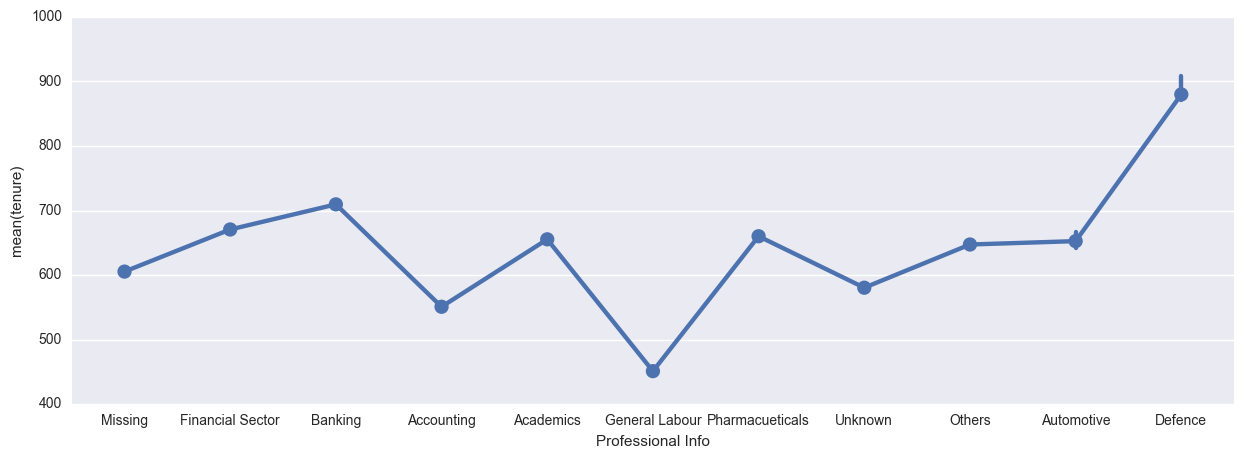

In [73]:
plt.figure(figsize=(15,5))
sns.pointplot(x="Professional Info", y="tenure", data=m_comu3, ci=10, aspect=68)
plt.savefig('profinfo_vs_tenure1.jpg')

Customers with very low salary bracket churns the most. The churn rate decreases as the salary slab bracket profile increases(very low to high profile)

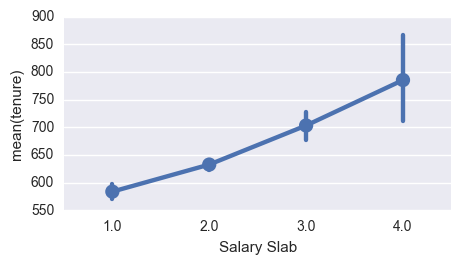

In [74]:
plt.figure(figsize=(5,2.5))
sns.pointplot(x="Salary Slab", y="tenure", data=m_comu3, ci=95)
plt.savefig('salaryslab_vs_tenure1.jpg')

Customers with second hand equipments are least likely to churn as compared to rented and bought equipments while customers with three full years equipment warranty churn the most.

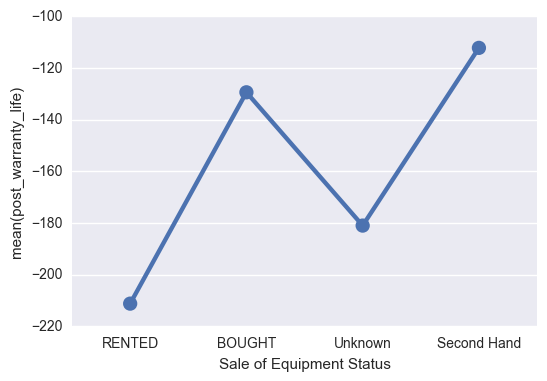

In [75]:
sns.pointplot(x="Sale of Equipment Status", y="post_warranty_life", data=m_comu3,ci=None)
plt.savefig('Sale of Equipment Status.jpg')

Salary Slabs 1,2,3 and 4 have mean tenure in ascending order. It means that people in salary slab 4 are the most faithfull customers in terms of days spent in the system

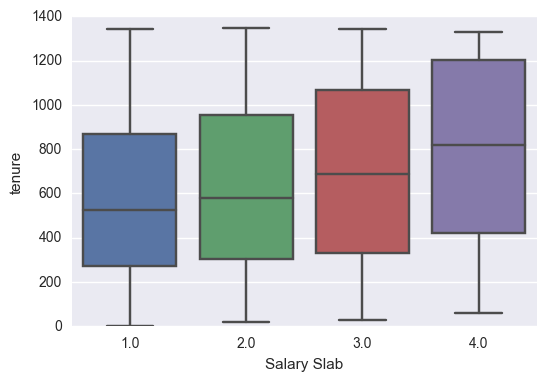

In [76]:
sns.boxplot(x="Salary Slab", y="tenure", data=m_comu3)
plt.savefig('salaryslab_tenure_boxplot.jpg')

All the churning customers irrespective of salary slab possess a trend of dropping the service shortly after warranty expiration. It happens only in salary slab 1 that non-churning people use the ISP instrument for too long after warranty expiration.

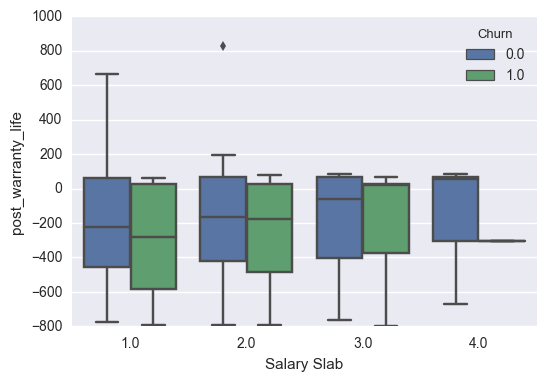

In [77]:
sns.boxplot(x="Salary Slab", y="post_warranty_life", data=m_comu3, hue="Churn")
plt.savefig('salaryslab_postwarrantylife_boxplot.jpg')

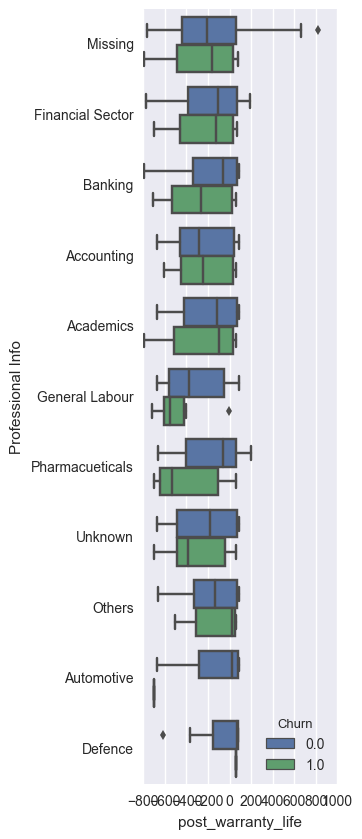

In [78]:
plt.figure(figsize=(2.5,10))
sns.boxplot(y="Professional Info", x="post_warranty_life", data=m_comu3, hue="Churn")
plt.savefig('profinfo_postwarrantylife_boxplot.jpg')

**User Characteristics**

month wise payment *vs* usage 

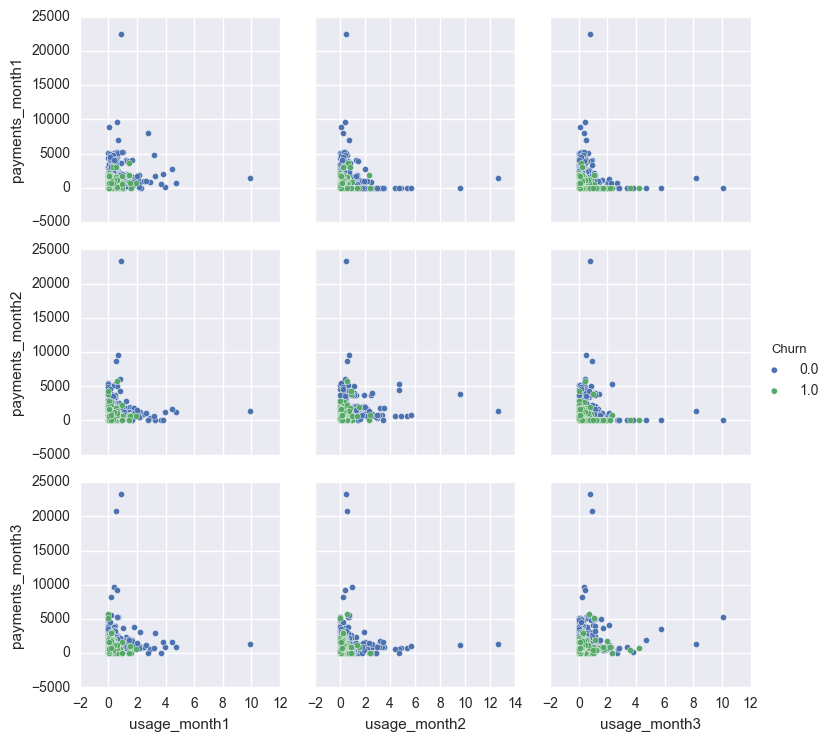

In [79]:
sns.pairplot(x_vars=["usage_month1","usage_month2","usage_month3"], y_vars=["payments_month1","payments_month2","payments_month3"], data=m_comu3,hue="Churn", size=2.5)
plt.savefig('use_pay_mcomu3.jpg')

month wise payments *vs* defaulters data

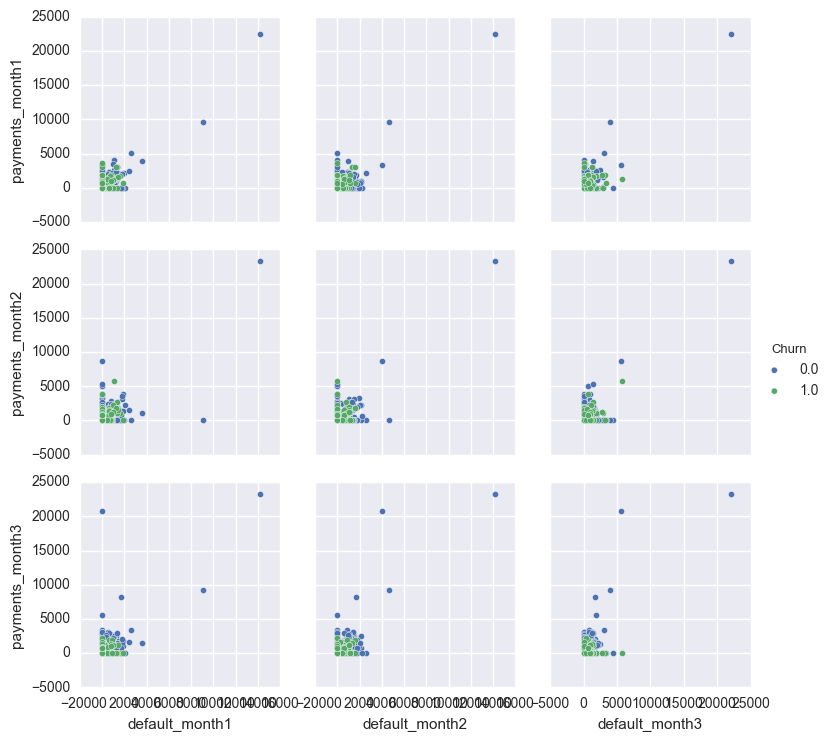

In [80]:
sns.pairplot(x_vars=["default_month1","default_month2","default_month3"], y_vars=["payments_month1","payments_month2","payments_month3"], data=m_comu3,hue="Churn", size=2.5)
plt.savefig('default_pay_mcomu3.jpg')

month wise defaulters data *vs* usage 

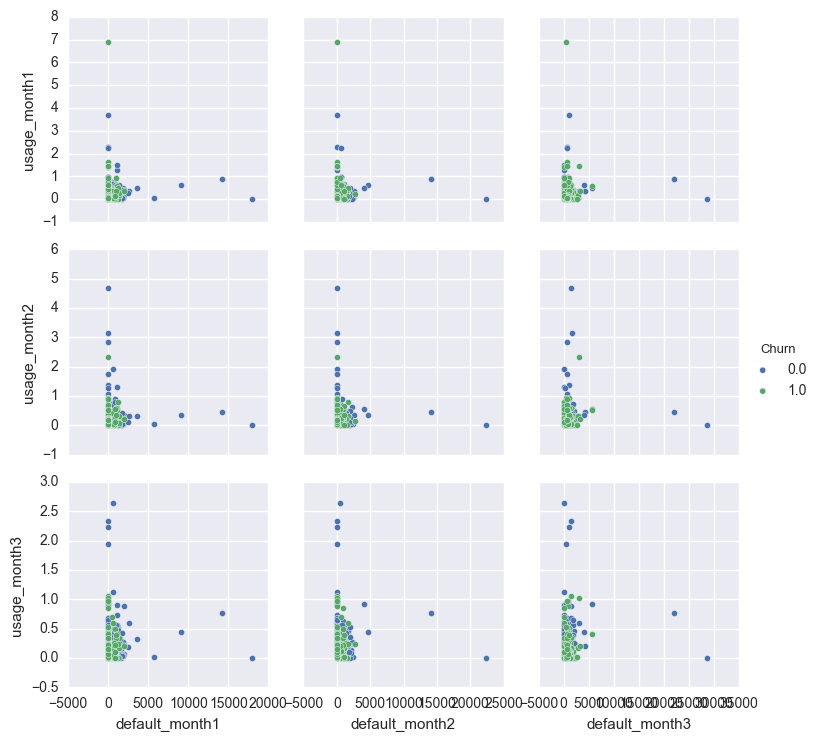

In [81]:
sns.pairplot(x_vars=["default_month1","default_month2","default_month3"], y_vars=["usage_month1","usage_month2","usage_month3"], data=m_comu3,hue="Churn", size=2.5)
plt.savefig('default_use_mcomu3.jpg')

Following plot is made to make out whether churning pattern of customers is region specific or not. As it can be seen, it is not. Out of all the regions, Western has the customers with the highest tenure

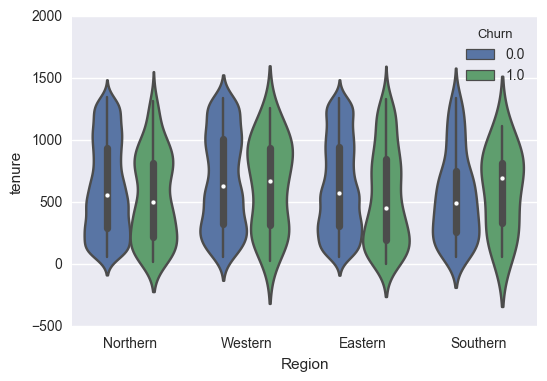

In [82]:
sns.violinplot(x='Region', y='tenure', hue='Churn', data=m_comu3)
plt.savefig('violin_region_tenure')

After studying above plots, I have exported my dataframe to an excel file named *comu3_d* for manipulations that are easy on excel format

In [86]:
#comu3.to_excel('H:/data science/exl eq 2017/comu3_d.xlsx')
comu3_d = pd.read_excel('H:/data science/exl eq 2017/comu3_d.xlsx')

Following has been done on excel: 
***
1.Since there were too many missing values in the defaults section, the three months default amount columns have beeen transformed to a single column *total defaults*, which takes values 0,1,2 and 3, indicating number of defaults in three months.                         
2.The four columns depicting the mode of payment, namely *Mode _ Card I TYPE, Mode _ Card II TYPE, Mode _Other, Mode _Paper based/Post* have been omitted because of difficulty in usage and bias created by them.	

In [89]:
comu3_d.head()

,Account Number,Commence Date,Address,Scheme,Staus,Gender,Region,Sale of Equipment Status,Age,Equipment Warranty,Salary Slab,Professional Info,Age of Home,Equipment Warranty Expiry Date,Churn Date,Churn,warranty_active,post_warranty_life,tenure,eqipment_warranty_length,no.of enquires,total defaults,usage_month1,usage_month2,usage_month3,Sum,payments_month1,payments_month2,payments_month3
0,M1,2011-11-04,1.0,KLA,1.0,0.0,Northern,RENTED,70.0,Three Full Years,2.0,Missing,17.0,2015-04-03,NaN,0.0,0.0,58.0,1304.0,1246.0,NaN,0,0.061011,0.166586,0.171898,3629.430,1209.810,1209.810,1209.810
1,M2,2011-11-28,1.0,PPL,1.0,0.0,Western,RENTED,55.0,Three Full Years,3.0,Missing,22.0,2015-04-03,NaN,0.0,0.0,58.0,1280.0,1222.0,6.0,0,0.140347,0.108676,0.208766,2255.085,751.695,751.695,751.695
2,M3,2011-12-06,1.0,KLA,1.0,1.0,Eastern,RENTED,64.0,Three Full Years,1.0,Financial Sector,17.0,2016-04-03,NaN,0.0,1.0,-308.0,1272.0,1580.0,NaN,0,0.094696,0.093891,0.100978,3193.155,1064.385,1064.385,1064.385
3,M4,2011-10-28,1.0,MXX,1.0,0.0,Northern,RENTED,66.0,Three Full Years,2.0,Banking,22.0,2015-04-03,NaN,0.0,0.0,58.0,1311.0,1253.0,NaN,0,0.078980,0.084741,0.094617,4126.500,963.375,1674.750,1488.375
4,M5,2015-01-18,1.0,PRP,1.0,0.0,Western,RENTED,52.0,Full Year,1.0,Missing,12.0,2016-01-03,NaN,0.0,1.0,-217.0,133.0,350.0,1.0,0,0.043780,0.009037,0.002340,2616.180,839.895,919.590,856.695


In [90]:
comu3_d.columns

Index(['Account Number', 'Commence Date', 'Address', 'Scheme', 'Staus',
       'Gender', 'Region', 'Sale of Equipment Status', 'Age',
       'Equipment Warranty', 'Salary Slab', 'Professional Info', 'Age of Home',
       'Equipment Warranty Expiry Date', 'Churn Date', 'Churn',
       'warranty_active', 'post_warranty_life', 'tenure',
       'eqipment_warranty_length', 'no.of enquires', 'total defaults',
       'usage_month1', 'usage_month2', 'usage_month3', 'Sum',
       'payments_month1', 'payments_month2', 'payments_month3'],
      dtype='object')

Rearranging the columns:

In [91]:
comu3_d = comu3_d[['Account Number', 'Commence Date', 'Address', 'Scheme', 'Staus',
       'Gender', 'Region', 'Sale of Equipment Status', 'Age',
       'Equipment Warranty', 'Salary Slab', 'Professional Info', 'Age of Home',
       'Equipment Warranty Expiry Date', 'Churn Date', 'Churn',
       'warranty_active', 'no.of enquires','total defaults','usage_month1', 'usage_month2',
       'usage_month3','Sum', 'payments_month1', 'payments_month2',
       'payments_month3','eqipment_warranty_length', 'post_warranty_life', 'tenure']]

Dropping those data samples which are missing in the demographic data and are oppearing on user characteristics. We dont have information of target variable for these account numbers, hence, keeping them will disturb our model by creating ambiguity in their recognition by the model parameters.

In [92]:
comu3_d = comu3_d.dropna(subset = ['Age'])

Printing the index of column names for further use:

In [93]:
for i,cols in enumerate(comu3_d.columns):
    print(i,cols)

0 Account Number
1 Commence Date
2 Address
3 Scheme
4 Staus
5 Gender
6 Region
7 Sale of Equipment Status
8 Age
9 Equipment Warranty
10 Salary Slab
11 Professional Info
12 Age of Home
13 Equipment Warranty Expiry Date
14 Churn Date
15 Churn
16 warranty_active
17 no.of enquires
18 total defaults
19 usage_month1
20 usage_month2
21 usage_month3
22 Sum
23 payments_month1
24 payments_month2
25 payments_month3
26 eqipment_warranty_length
27 post_warranty_life
28 tenure


The missing values in the recently added user information to the demographic data has many missing values. Replacing them by the mean of their respective columns:

In [94]:
for i in range(19,26):
    comu3_d.iloc[:,i] = comu3_d.iloc[:,i].fillna(comu3_d.iloc[:,i].mean(), axis=0)

Filling the nan in the *no.of enquires* column by 0

In [95]:
comu3_d.iloc[:,17] = comu3_d.iloc[:,17].fillna(0, axis=0)

In [96]:
comu3_d.isnull().sum()

Account Number                        0
Commence Date                         0
Address                               0
Scheme                                0
Staus                                 0
Gender                                0
Region                                0
Sale of Equipment Status              0
Age                                   0
Equipment Warranty                    0
Salary Slab                           0
Professional Info                     0
Age of Home                           0
Equipment Warranty Expiry Date        0
Churn Date                        14446
Churn                                 0
warranty_active                       0
no.of enquires                        0
total defaults                        0
usage_month1                          0
usage_month2                          0
usage_month3                          0
Sum                                   0
payments_month1                       0
payments_month2                       0


In [97]:
comu3_d.head()

,Account Number,Commence Date,Address,Scheme,Staus,Gender,Region,Sale of Equipment Status,Age,Equipment Warranty,Salary Slab,Professional Info,Age of Home,Equipment Warranty Expiry Date,Churn Date,Churn,warranty_active,no.of enquires,total defaults,usage_month1,usage_month2,usage_month3,Sum,payments_month1,payments_month2,payments_month3,eqipment_warranty_length,post_warranty_life,tenure
0,M1,2011-11-04,1.0,KLA,1.0,0.0,Northern,RENTED,70.0,Three Full Years,2.0,Missing,17.0,2015-04-03,NaN,0.0,0.0,0.0,0,0.061011,0.166586,0.171898,3629.430,1209.810,1209.810,1209.810,1246.0,58.0,1304.0
1,M2,2011-11-28,1.0,PPL,1.0,0.0,Western,RENTED,55.0,Three Full Years,3.0,Missing,22.0,2015-04-03,NaN,0.0,0.0,6.0,0,0.140347,0.108676,0.208766,2255.085,751.695,751.695,751.695,1222.0,58.0,1280.0
2,M3,2011-12-06,1.0,KLA,1.0,1.0,Eastern,RENTED,64.0,Three Full Years,1.0,Financial Sector,17.0,2016-04-03,NaN,0.0,1.0,0.0,0,0.094696,0.093891,0.100978,3193.155,1064.385,1064.385,1064.385,1580.0,-308.0,1272.0
3,M4,2011-10-28,1.0,MXX,1.0,0.0,Northern,RENTED,66.0,Three Full Years,2.0,Banking,22.0,2015-04-03,NaN,0.0,0.0,0.0,0,0.078980,0.084741,0.094617,4126.500,963.375,1674.750,1488.375,1253.0,58.0,1311.0
4,M5,2015-01-18,1.0,PRP,1.0,0.0,Western,RENTED,52.0,Full Year,1.0,Missing,12.0,2016-01-03,NaN,0.0,1.0,1.0,0,0.043780,0.009037,0.002340,2616.180,839.895,919.590,856.695,350.0,-217.0,133.0


Now our dataframe is ready for putting in the model. But before that, outlier treatment must be dealt with care. In the above scatter plots, we saw that outliers exist in the payment, default and usage columns. Default columns are already transformed as stated above. I have preferred binning over outlier removal to ensure no loss of data. All data samples are categorised into 4 bins :

In [98]:
binned = comu3_d.copy()

In [99]:
def outliers_iqr(ys):
    quartile_1, quartile_2, quartile_3 = np.percentile(ys, [25, 50, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return(quartile_1, quartile_2, quartile_3,lower_bound,upper_bound)      

In [101]:
for i in range(19,29):
    a,b,c,d,e = outliers_iqr(comu3_d[comu3_d.iloc[:,i] != 0].iloc[:,i])
    feat = comu3_d.columns[i]
    for index, row in comu3_d.iterrows():
        x = row[feat]
        if(x<a):
            y=1
        elif(a<=x<b):
            y=2
        elif(b<=x<c):
            y=3
        elif(x>=c):
            y=4
        binned.set_value(index,feat,y)        

In [102]:
binned.head()

,Account Number,Commence Date,Address,Scheme,Staus,Gender,Region,Sale of Equipment Status,Age,Equipment Warranty,Salary Slab,Professional Info,Age of Home,Equipment Warranty Expiry Date,Churn Date,Churn,warranty_active,no.of enquires,total defaults,usage_month1,usage_month2,usage_month3,Sum,payments_month1,payments_month2,payments_month3,eqipment_warranty_length,post_warranty_life,tenure
0,M1,2011-11-04,1.0,KLA,1.0,0.0,Northern,RENTED,70.0,Three Full Years,2.0,Missing,17.0,2015-04-03,NaN,0.0,0.0,0.0,0,2.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
1,M2,2011-11-28,1.0,PPL,1.0,0.0,Western,RENTED,55.0,Three Full Years,3.0,Missing,22.0,2015-04-03,NaN,0.0,0.0,6.0,0,3.0,2.0,4.0,2.0,2.0,2.0,2.0,4.0,4.0,4.0
2,M3,2011-12-06,1.0,KLA,1.0,1.0,Eastern,RENTED,64.0,Three Full Years,1.0,Financial Sector,17.0,2016-04-03,NaN,0.0,1.0,0.0,0,2.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0
3,M4,2011-10-28,1.0,MXX,1.0,0.0,Northern,RENTED,66.0,Three Full Years,2.0,Banking,22.0,2015-04-03,NaN,0.0,0.0,0.0,0,2.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
4,M5,2015-01-18,1.0,PRP,1.0,0.0,Western,RENTED,52.0,Full Year,1.0,Missing,12.0,2016-01-03,NaN,0.0,1.0,1.0,0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,1.0,2.0,1.0


In [103]:
for i in range(18,28):
    print(binned.columns[i], binned[binned.columns[i]].value_counts())

total defaults 0    13225
1     1185
2      358
3      184
Name: total defaults, dtype: int64
usage_month1 1.0    4635
4.0    3439
3.0    3439
2.0    3439
Name: usage_month1, dtype: int64
usage_month2 1.0    4346
4.0    3536
3.0    3535
2.0    3535
Name: usage_month2, dtype: int64
usage_month3 1.0    4039
4.0    3638
3.0    3638
2.0    3637
Name: usage_month3, dtype: int64
Sum 2.0    3841
3.0    3744
4.0    3738
1.0    3629
Name: Sum, dtype: int64
payments_month1 1.0    4746
3.0    3444
4.0    3395
2.0    3367
Name: payments_month1, dtype: int64
payments_month2 1.0    5006
3.0    4051
4.0    3288
2.0    2607
Name: payments_month2, dtype: int64
payments_month3 1.0    4281
4.0    3557
3.0    3557
2.0    3557
Name: payments_month3, dtype: int64
eqipment_warranty_length 3.0    7727
4.0    3738
1.0    3487
Name: eqipment_warranty_length, dtype: int64
post_warranty_life 4.0    3763
3.0    3752
2.0    3721
1.0    3716
Name: post_warranty_life, dtype: int64


In [105]:
binned.to_excel('H:/data science/exl eq 2017/binned_mean.xlsx')

In [2]:
binned = pd.read_excel('H:/data science/exl eq 2017/binned_mean.xlsx')

In [3]:
binned.head(2)

,Account Number,Commence Date,Address,Scheme,Staus,Gender,Region,Sale of Equipment Status,Age,Equipment Warranty,Salary Slab,Professional Info,Age of Home,Equipment Warranty Expiry Date,Churn Date,Churn,warranty_active,no.of enquires,total defaults,usage_month1,usage_month2,usage_month3,Sum,payments_month1,payments_month2,payments_month3,eqipment_warranty_length,post_warranty_life,tenure
0,M1,2011-11-04,1,KLA,1,0,Northern,RENTED,70,Three Full Years,2,Missing,17,2015-04-03,NaN,0,0,0,0,2,3,3,4,4,4,4,4,4,4
1,M2,2011-11-28,1,PPL,1,0,Western,RENTED,55,Three Full Years,3,Missing,22,2015-04-03,NaN,0,0,6,0,3,2,4,2,2,2,2,4,4,4


Following code deals with preparing our dataframe to fit into the model:

In [4]:
#modelling begins here
model = binned.copy()

In [5]:
model['Commence Date'] =  pd.to_datetime(model['Commence Date'])
model['Equipment Warranty Expiry Date'] =  pd.to_datetime(model['Equipment Warranty Expiry Date'])
model['Churn Date'] =  pd.to_datetime(model['Churn Date'])

Breaking dates into year, month, weekday to convert their dtype from datetime to float.

In [6]:
model['month_ew'] = model['Equipment Warranty Expiry Date'].dt.month
model['weekday_ew'] = model['Equipment Warranty Expiry Date'].dt.weekday
model['year_ew'] = model['Equipment Warranty Expiry Date'].dt.year

model['month_cd'] = model['Commence Date'].dt.month
model['weekday_cd'] = model['Commence Date'].dt.weekday
model['year_cd'] = model['Commence Date'].dt.year

model = pd.get_dummies(model, columns=['Scheme','Region','Sale of Equipment Status','Equipment Warranty','Professional Info'])

*Tenure* and *post_warranty_life* are may create bias for validation data samples because we dont have information of their churn pattern. To be on the safer side, its better to drop these features from our model.

In [7]:
model_dropped = model[['tenure', 'post_warranty_life']]
model.drop(['tenure', 'post_warranty_life'], axis=1, inplace = True)

In [8]:
model.tail()

,Account Number,Commence Date,Address,Staus,Gender,Age,Salary Slab,Age of Home,Equipment Warranty Expiry Date,Churn Date,Churn,warranty_active,no.of enquires,total defaults,usage_month1,usage_month2,usage_month3,Sum,payments_month1,payments_month2,payments_month3,eqipment_warranty_length,month_ew,weekday_ew,year_ew,month_cd,weekday_cd,year_cd,Scheme_CHC,Scheme_CNN,Scheme_ESS,Scheme_KLA,Scheme_MXX,Scheme_PMM,Scheme_POP,Scheme_PPL,Scheme_PRM,Scheme_PRP,Scheme_PRR,Scheme_PRS,Scheme_PWM,Scheme_PWP,Scheme_PWR,Region_Eastern,Region_Northern,Region_Southern,Region_Western,Sale of Equipment Status_BOUGHT,Sale of Equipment Status_RENTED,Sale of Equipment Status_Second Hand,Sale of Equipment Status_Unknown,Equipment Warranty_Full Year,Equipment Warranty_Full Year Plus 3 Months,Equipment Warranty_Three Full Years,Professional Info_Academics,Professional Info_Accounting,Professional Info_Automotive,Professional Info_Banking,Professional Info_Defence,Professional Info_Financial Sector,Professional Info_General Labour,Professional Info_Missing,Professional Info_Others,Professional Info_Pharmacueticals,Professional Info_Unknown
14947,V4996,2011-12-08,1,1,0,57,2,22,2015-07-23,NaT,0,1,0,0,1,1,1,3,3,3,3,4,7,3,2015,12,3,2011,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14948,V4997,2012-02-13,1,1,1,65,2,21,2015-07-29,NaT,0,1,0,0,2,2,2,3,3,3,3,4,7,2,2015,2,0,2012,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14949,V4998,2012-06-24,1,1,1,52,2,21,2015-07-25,NaT,0,1,0,0,4,4,4,3,3,3,3,4,7,5,2015,6,6,2012,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14950,V4999,2013-11-28,1,1,1,46,3,22,2016-08-03,NaT,0,1,0,0,3,2,1,3,3,3,3,4,8,2,2016,11,3,2013,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14951,V5000,2011-10-24,1,1,1,73,2,22,2015-08-04,NaT,0,1,0,0,4,3,3,3,3,3,3,4,8,1,2015,10,0,2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
m = model[model['Account Number'].str.startswith('M')]
v = model[model['Account Number'].str.startswith('V')]

In [10]:
len(m)

9966

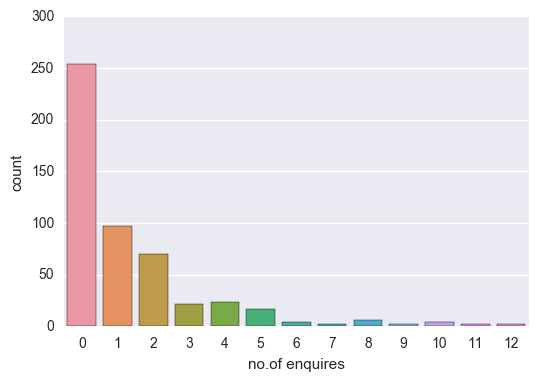

In [11]:
enquires_churn = m[m['Churn'] == 1]['no.of enquires']
sns.countplot(enquires_churn)
plt.savefig('churned+enquires_count.jpg')

plotting the corrleations of all features with respect to the target variable

In [12]:
m_corr = m.corr()
m_corr[['Churn']].sort_values(by = 'Churn', ascending=False)

,Churn
Churn,1.000000
total defaults,0.163630
no.of enquires,0.076666
Scheme_ESS,0.049494
Professional Info_Missing,0.032007
Scheme_MXX,0.031666
year_cd,0.030350
Professional Info_Others,0.020172
Professional Info_Accounting,0.019050
Equipment Warranty_Three Full Years,0.015046


In [13]:
Churn = m.Churn
m.drop('Churn', axis=1, inplace=True)

C:\Users\parag\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [14]:
v_dropped = v[['Account Number','Equipment Warranty Expiry Date','Commence Date', 'Churn Date','Churn']]
v.drop(['Account Number','Equipment Warranty Expiry Date','Commence Date', 'Churn Date', 'Churn'], axis=1, inplace = True)

m_dropped = m[['Account Number','Equipment Warranty Expiry Date','Commence Date', 'Churn Date']]
m.drop(['Account Number','Equipment Warranty Expiry Date','Commence Date', 'Churn Date'], axis=1, inplace = True)

C:\Users\parag\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\parag\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
m.shape

(9966, 60)

In [16]:
v.shape

(4986, 60)

Scaling the features for uniformity:

In [17]:
from sklearn.preprocessing import StandardScaler as ss
m_std = ss().fit_transform(m)
v_std = ss().fit_transform(v)

Breaking our modelling set into train and test for model parameters and cut-off determination:

In [18]:
from sklearn.cross_validation import train_test_split
m_train, m_test, Churn_train, Churn_test = train_test_split(m_std, Churn, test_size=0.3, random_state=42)

C:\Users\parag\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
len(m_std)

9966

In [20]:
len(Churn)

9966

In [21]:
len(m_train)

6976

Since our data is imbalanced because less than 10% of the target variable is 1 and rest all are 0. To deal with this imbalance, we'll increase the samples by using SMOTE. This makes extra samples of minor class by oversampling in particular regions.

In [22]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
m_train, Churn_train = sm.fit_sample(m_std, Churn)

In [23]:
len(m_train)

18920

In [24]:
len(Churn_train)

18920

In [32]:
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.feature_selection import SelectFromModel
clf = ETC(n_estimators=250)
clf = clf.fit(m_train, Churn_train)

In [33]:
features = pd.DataFrame()
features['feature'] = m.columns
features['importance'] = clf.feature_importances_
features.sort(['importance'],ascending=False)

C:\Users\parag\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,importance
1,Staus,0.065908
8,total defaults,0.046776
2,Gender,0.045917
5,Age of Home,0.045860
12,Sum,0.043647
15,payments_month3,0.040526
56,Professional Info_Missing,0.033965
14,payments_month2,0.033360
11,usage_month3,0.033199
38,Region_Eastern,0.032088


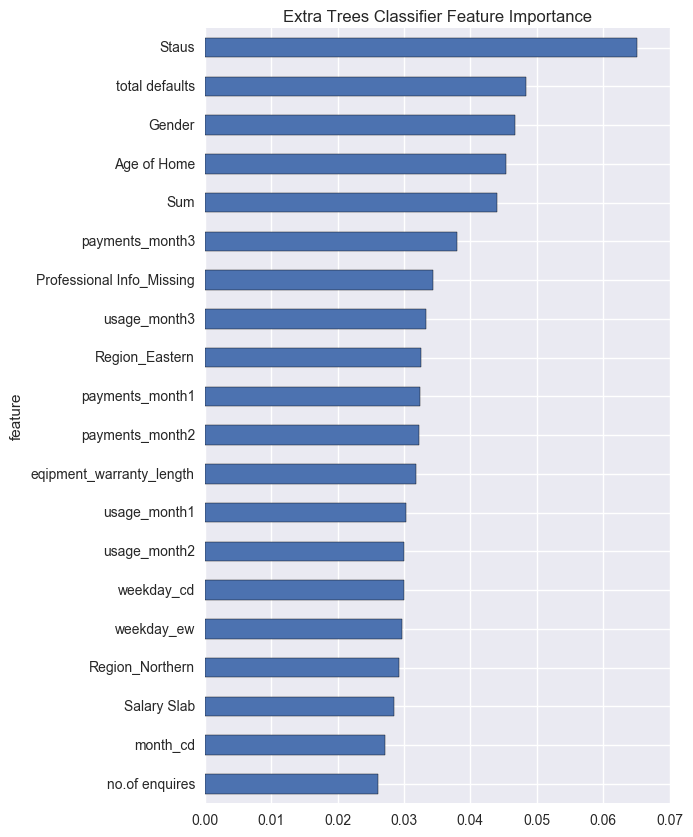

In [27]:
featp = features.sort_values(by='importance')[-20:].plot(kind='barh', x='feature', y='importance', legend=False, figsize=(6, 10))
plt.title('Extra Trees Classifier Feature Importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_gbc.png', bbox_inches='tight', pad_inches=1)

In [136]:
model = SelectFromModel(clf, prefit=True)
m_std = model.transform(m_std)
m_std.shape

(9966, 22)

In [139]:
model = SelectFromModel(clf, prefit=True)
m_train = model.transform(m_train)
m_train.shape

(18920, 22)

In [140]:
model = SelectFromModel(clf, prefit=True)
m_test = model.transform(m_test)
m_test.shape

(2990, 22)

In [137]:
v_std = model.transform(v_std)
v_std.shape

(4986, 22)

In [138]:
Churn.shape

(9966,)

In [141]:
Churn_train.shape

(18920,)

In [142]:
Churn_test.shape

(2990,)

In [143]:
m_std = pd.DataFrame(m_std)
Churn = pd.DataFrame(Churn)
v_std = pd.DataFrame(v_std)
m_train = pd.DataFrame(m_train)
m_test = pd.DataFrame(m_test)
Churn_train = pd.DataFrame(Churn_train)
Churn_test = pd.DataFrame(Churn_test)

In [145]:
m_std.to_csv('H:\data science\exl eq 2017\m_std.csv')
Churn.to_csv('H:\data science\exl eq 2017\Churn.csv')
v_std.to_csv('H:/data science/exl eq 2017/v_std.csv')
m_train.to_csv('H:\data science\exl eq 2017\m_train.csv')
m_test.to_csv('H:\data science\exl eq 2017\m_test.csv')
Churn_train.to_csv('H:\data science\exl eq 2017\Churn_train.csv')
Churn_test.to_csv('H:\data science\exl eq 2017\Churn_test.csv')

#Get to the directory where you have the files  
setwd('H:/data science/exl eq 2017')  
   
library(xgboost)  
library(Matrix)   
library(caret)   
library(ROSE)   

X <- read.csv('m_train.csv')[,-1]   
y <- read.csv('Churn_train.csv')[,-1]   


#Using xgboost with default parameters, play with the parameter to get better results    
xgb <- xgboost(data = data.matrix(X),      
               label = y,     
               eta = 0.1,     
               max_depth = 15,      
               nround = 150,      
               subsample = 0.5,     
               colsample_bytree = 0.5,     
               seed = 2543,     
               eval_metric = "merror",     
               objective = "multi:softprob",     
               num_class = 2,     
               nthread = 3     
)

test <- read.csv('m_test.csv')[,-1]    
churn <- read.csv('Churn_test.csv')    

pred <- predict(xgb, data.matrix(test), type = 'prob')    

j = 1   
for(i in (1:length(pred))){    
  if(i %% 2 == 0){    
    churn$prob[j] = pred[i]   
    j = j+1    
  }    
}    

#Calculates auc     
auc = roc.curve(churn$Churn, churn$prob)     
print(auc)     

#calculates accuracy for different threshold     
accuracy = accuracy.meas(churn$Churn, churn$prob, threshold = 0.05)     
print(accuracy)     

#confusion matrix for threshold = 0.05     
table(churn$Churn, churn$prob >= 0.05)    
